In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import json
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

<h3>Loading Data</h3>

In [2]:
train_json = 'train.json'
test_json = 'test.json'
images_path = 'performing_detection/agri_data/'
model_path  = 'RCNN_crop_weed_classification_model.h5'
label_csv = 'performing_detection/agri_label.csv'
negative_ex_path = 'Train/background/'

<h3>Loading pre generated region proposals and Negative examples</h3>

In [3]:
with open(train_json,'r') as train:
    train_region = json.load(train)

In [4]:
with open(test_json,'r') as test:
    test_region = json.load(test)

In [5]:
train_images_list = list(train_region.keys())
test_images_list = list(test_region.keys())

In [6]:
print(len(train_images_list))
print(len(test_images_list))

1000
300


<h3>Loading object annotation</h3>

In [7]:
labels = pd.read_csv(label_csv)
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,agri_0_9354.jpeg,512,512,weed,63,120,425,442
1,agri_0_9354.jpeg,512,512,weed,0,1,180,148
2,agri_0_7574.jpeg,512,512,crop,95,167,453,469
3,agri_0_8960.jpeg,512,512,weed,52,76,422,353
4,agri_0_417.jpeg,512,512,weed,7,75,511,411


<h3>Loading pretrained CNN model</h3>

In [8]:
model = tf.keras.models.load_model(model_path)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<h3>loading model without last two Fully connected layers</h3>

In [10]:
model_without_last_2FC = tf.keras.models.Model(model.inputs,model.layers[-5].output)

In [11]:
model_without_last_2FC.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<h3>Extracting features from ground truth labeled images</h3>

In [12]:
train_features = []

test_features = []


for index in tqdm(range(len(labels))):
    id = labels.loc[index,'filename']
    img = cv2.imread(images_path + id)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    xmin,ymin,xmax,ymax = int(labels.loc[index,'xmin']) ,int(labels.loc[index,'ymin']),int(labels.loc[index,'xmax']),int(labels.loc[index,'ymax'])

    resized = cv2.resize(rgb_img[ymin:ymax,xmin:xmax,:],(224,224))

    feature_of_img = model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255)
    
    if id in train_images_list:
        
        train_features.append([feature_of_img,labels.loc[index,'class']])
        
    else:
        test_features.append([feature_of_img,labels.loc[index,'class']])

100%|██████████████████████████████████████████████████████████████████████████████| 2072/2072 [17:19<00:00,  1.99it/s]


In [13]:
print(len(train_features))

print(len(test_features))

1637
435


<h3>Extracting features from Negative examples</h3>

In [14]:
for index,img in tqdm(enumerate(os.listdir(negative_ex_path)[:5000])):  #only extracting for 10,000 images
    img = cv2.imread(negative_ex_path + img )
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #images already in (224,224,3)
    feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)
    if index<3500:
        train_features.append([feature_of_img,'background'])
    else:
        test_features.append([feature_of_img,'background'])

5000it [26:49,  3.11it/s]


<h3>Preparing data for SVM</h3>

In [15]:
import random
random.shuffle(train_features)

In [16]:
X_train = np.array([x[0] for x in train_features])
X_train = X_train.reshape(-1,4096)

In [17]:
X_train.shape

(5137, 4096)

In [18]:
y_train = [x[1] for x in train_features]
y_train = np.array(y_train).reshape(-1,1)

In [19]:
y_train.shape

(5137, 1)

In [20]:
X_test = np.array([x[0] for x in test_features])
X_test = X_test.reshape(-1,4096)

In [21]:
y_test = [x[1] for x in test_features]
y_test = np.array(y_test).reshape(-1,1)

<h3>SVM Training</h3>

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report

In [23]:
svm_model_linear = SVC(kernel = 'linear', C = 1,probability=True).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test)

In [24]:
accuracy = svm_model_linear.score(X_test, y_test)

In [25]:
accuracy

0.9679586563307494

<AxesSubplot:>

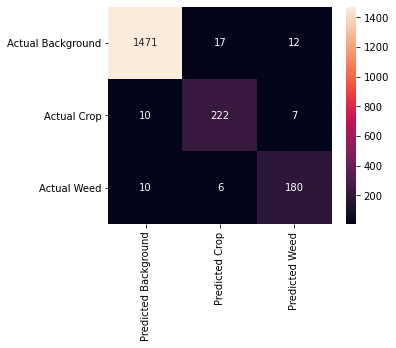

In [29]:
cm = pd.DataFrame(data=confusion_matrix(y_test, svm_predictions, labels=["background","crop","weed"]),index=["Actual Background", "Actual Crop","Actual Weed"],
columns=["Predicted Background", "Predicted Crop" , "Predicted Weed"])
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,4))
plt.rcParams.update({'font.size': 10})
sns.heatmap(cm,annot=True,fmt="d",ax=ax)

<h3>Check on some images</h3>

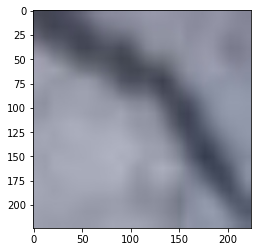

In [30]:
img = cv2.imread(negative_ex_path + os.listdir(negative_ex_path)[45] )
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

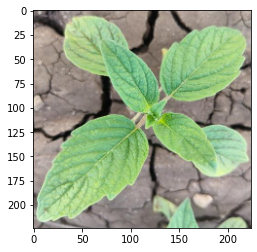

In [31]:
plt.imshow(resized)

In [32]:
svm_model_linear.predict_proba(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array([[4.05138582e-12, 9.99999900e-01, 9.98909688e-08]])

<h3>Saving SVM model</h3>

In [33]:
import pickle

with open('svm_classifier.pkl','wb') as svm_model:
    pickle.dump(svm_model_linear , svm_model)